In [189]:
## imports

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from ast import literal_eval

In [2]:
# other imports
from itscalledsoccer.client import AmericanSoccerAnalysis
asa_client = AmericanSoccerAnalysis()

Gathering all players
Gathering all teams
Gathering all stadia
Gathering all managers
Gathering all referees
Finished initializing client


### Getting the data from the API

In [3]:
stadia = asa_client.get_stadia(leagues='mls')
stadia.columns.to_list()

['stadium_id',
 'stadium_name',
 'capacity',
 'year_built',
 'roof',
 'turf',
 'street',
 'city',
 'province',
 'country',
 'postal_code',
 'latitude',
 'longitude',
 'field_x',
 'field_y',
 'competition']

In [4]:
refrees = asa_client.get_referees(leagues='mls')
refrees.columns.to_list()

['referee_id', 'referee_name', 'nationality', 'birth_date', 'competition']

In [5]:
managers = asa_client.get_managers(leagues='mls')
managers.columns.to_list()

['manager_id', 'manager_name', 'nationality', 'competition']

In [6]:
teams = asa_client.get_teams(leagues='mls')
teams.columns.to_list()

['team_id', 'team_name', 'team_short_name', 'team_abbreviation', 'competition']

In [7]:
players = asa_client.get_players(leagues='mls')
players.columns.to_list()

['player_id',
 'player_name',
 'birth_date',
 'nationality',
 'primary_broad_position',
 'primary_general_position',
 'secondary_broad_position',
 'secondary_general_position',
 'season_name',
 'height_ft',
 'height_in',
 'weight_lb',
 'competition']

In [8]:
games = asa_client.get_games(leagues='mls')
games.columns.to_list()

['game_id',
 'date_time_utc',
 'home_score',
 'away_score',
 'home_team_id',
 'away_team_id',
 'referee_id',
 'stadium_id',
 'home_manager_id',
 'away_manager_id',
 'expanded_minutes',
 'season_name',
 'matchday',
 'attendance',
 'knockout_game',
 'last_updated_utc',
 'extra_time',
 'penalties',
 'home_penalties',
 'away_penalties']

### Functions to filter the data

In [222]:
def filter_metric(players_df, games_df, client=asa_client, method='get_player_xgoals', start_season=2020, end_season=2023):
    '''
    returns df of player specific metric in the given season start to end ranges
    returned df contains the metric and the season_name column
    '''
    desired_range = [str(yr) for yr in list(range(start_season, end_season+1))]
    players_df = players_df[players_df['season_name'].apply(lambda seasons: set(seasons).issuperset(set(desired_range)))]    
    
    # getting the specific metric
    player_id_list = list(players_df.player_id.unique())
    
    dfs = []
    
    # get the method based on the client and the method name specified as arguments
    if hasattr(client, method):
        func = getattr(client, method)
    
    # columns to keep based on provided method
    
    if method == 'get_player_xgoals':
        columns_to_keep = ['player_id', 'minutes_played','xgoals', 'xassists', 'season_name']
    if method == 'get_player_xpass':
        columns_to_keep = ['player_id', 'minutes_played', 'attempted_passes', 'xpass_completion_percentage','season_name']
    if method == 'get_player_goals_added' or method == 'get_goalkeeper_goals_added':
        columns_to_keep = ['player_id', 'minutes_played', 'data', 'season_name']   
    if method == 'get_goalkeeper_xgoals':
        columns_to_keep = ['player_id', 'minutes_played', 'xgoals_gk_faced', 'saves', 'goals_conceded','season_name']         
        
    # iterate to get the dfs per player id
    for player_id in tqdm(player_id_list):
        print(f"Getting the metrics for {player_id}") 
        df = func(leagues = 'mls', player_ids = player_id, season_name=desired_range, split_by_games = True)
        
        # filter to meet minimum play time
        df = df[df['minutes_played']>=30]
        
        # add season name to the df
        df = pd.merge(df, games_df, on='game_id', how='left')
        
        # keep only wanted columns
        df = df[columns_to_keep].sort_values(by='season_name')
        
        # if the columns to keeo has a data columns of dictionaries then do the following
        if 'data' in columns_to_keep:
            print('reorganizing columns')
            reorganized_df_list = [] 
            for i,row in df.iterrows():
                df_ = pd.json_normalize(row['data'])[['action_type', 'goals_added_raw']].T
                df_.columns = df_.iloc[0]
                df_ = df_[1:]
                reorganized_df_list.append(df_)

            reorganized_df = pd.concat(reorganized_df_list, axis = 0).reset_index(drop = True)
            
            # concatenate the reorganized df with the orginal df, drop the data column
            df = pd.concat([df, reorganized_df], axis = 1).drop('data', axis=1)
            df['goals_added_total'] = df['Dribbling'] + df['Fouling'] + df['Interrupting'] + df['Passing'] + df['Receiving']+ df['Shooting']
            
        dfs.append(df)
    
    # concatenate and return result
    df_concat = pd.concat(dfs, ignore_index=True)
    
    # write to csv
    folder = 'data'
    df_name = str(f'{players_df}')
    if not os.path.exists(folder):
        os.mkdirs(folder)
    export_path = folder + '/' + f'filtered_players'+ '_'+ f'{method}' + '.csv'
    print(export_path)
    df_concat.to_csv(export_path, index = False)
    
    return df_concat

In [223]:
## Latent Metrics - Discrimination

def discrimination_season(df, metric='xgoals', season = 2020):
    ''' returns discrimination ability of the metric in the specified season''' 
    
    # Noise to avoid zero division error
    eta = 0.001
    
    # Filter rows with non-null values in the specified column
    data = df[['season_name', 'player_id', metric]].dropna(subset=[metric])
    # Filter rows based on the specified season
    data = data[data['season_name'] == season]
    
    # Count the number of data points for each player
    # player_data_counts = data.groupby('player_id').size()

    # Filter out player_ids with less than two data points for the metric
    # valid_player_ids = player_data_counts[player_data_counts >= 2].index
    # data = data[data['player_id'].isin(valid_player_ids)]
    
    # Calculate sample intra_variance and sample cross_variance
    data['cross_variance'] = data[metric].var(ddof=0)
    result_data = data.groupby('player_id').agg(
        intra_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=0)),
        cross_variance=pd.NamedAgg(column='cross_variance', aggfunc='mean')
    )
    
    # Calculate and return the discrimination score
    return 1 - ((result_data['intra_variance'].mean()+eta) / (result_data['cross_variance'].mean()+eta))

In [224]:
# Latent metrics - Stability

def stability_scores(df, metric='xgoals'):
    '''
    returns the stability metric 
    '''
    # noise to avoid zero division error
    eta = 0.001
    
    btw_season_variance = df.groupby('player_id').agg(
       bs_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=0))
    )['bs_variance'].mean()
    
    within_season_player_variance = df.groupby(['player_id', 'season_name']).agg(
        wsp_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=0))
    )['wsp_variance'].mean()
    
    overall_variance = df[metric].var(ddof=0)
    
    stability = 1 - (((btw_season_variance - within_season_player_variance)+eta) / ((overall_variance - within_season_player_variance)+eta))
    
    return stability

### Filtering out the players of interest

In [225]:
# midfielders, primary position
players_midfield = players[players['primary_broad_position']== 'MF']

In [226]:
# select the midfielders who played in sesons 2020 to 2023
start_season = 2018
end_season = 2023
desired_range = [str(yr) for yr in list(range(start_season, end_season+1))]

players_midfield = players_midfield[players_midfield['season_name'].apply(lambda seasons: set(seasons).issuperset(set(desired_range)))]

In [227]:
players_midfield.shape

(57, 13)

In [228]:
players_midfield[['player_id', 'player_name']].reset_index(drop=True)

,player_id,player_name
0,0Oq6lyNdM6,Wil Trapp
1,0Oq6wv26Q6,Jonathan Lewis
2,0x5gXlrq7O,Roger Espinoza
3,2lqRRvNxqr,Scott Caldwell
4,2lqRRZy2qr,Ilie Sánchez
5,2vQ1LYxbqr,Paul Arriola
6,2vQ1LYY0qr,Emmanuel Boateng
7,4JMAaaxkMK,Sebastian Lletget
8,4wM42Belqj,Mark Delgado
9,7vQ73NxYQD,Kelyn Rowe


## Extracting the dataframe for the filtered players and range of seasons by API calls

In [229]:
xpasspercent = filter_metric(players_midfield, games, asa_client, 'get_player_xpass', start_season, end_season)

 12%|██████████▏                                                                        | 7/57 [00:00<00:00, 61.95it/s]

Getting the metrics for 0Oq6lyNdM6
Getting the metrics for 0Oq6wv26Q6
Getting the metrics for 0x5gXlrq7O
Getting the metrics for 2lqRRvNxqr
Getting the metrics for 2lqRRZy2qr
Getting the metrics for 2vQ1LYxbqr
Getting the metrics for 2vQ1LYY0qr
Getting the metrics for 4JMAaaxkMK
Getting the metrics for 4wM42Belqj
Getting the metrics for 7vQ73NxYQD
Getting the metrics for 7vQ7rPpOqD
Getting the metrics for 7VqGj3RA5v


 39%|███████████████████████████████▋                                                  | 22/57 [00:00<00:00, 63.87it/s]

Getting the metrics for 9vQ22OOoQK
Getting the metrics for 9vQ2d3X75K
Getting the metrics for 9vQ2dAKY5K
Getting the metrics for a35rlyZ4QL
Getting the metrics for aDQ0PjnGQE
Getting the metrics for BLMv1GlQxe
Getting the metrics for BLMvlPy3qx
Getting the metrics for e7Mz9DgGQr
Getting the metrics for eV5D9A9qKn
Getting the metrics for eV5DLedE5K
Getting the metrics for eVq3a8XyMW
Getting the metrics for eVq3apWvMW
Getting the metrics for eVq3jYZv5W
Getting the metrics for eVq3xXDDQW
Getting the metrics for gjMNv7PpMK
Getting the metrics for gjMNvjYvMK


 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [00:00<00:00, 76.50it/s]

Getting the metrics for gOMn66nAMw
Getting the metrics for gOMnR96lMw
Getting the metrics for gOMnRPxXMw
Getting the metrics for gpMOa6zrqz
Getting the metrics for gpMOyGlqzy
Getting the metrics for jYQJOaZMGR
Getting the metrics for KAqBjWZBqb
Getting the metrics for KPqj7jY4Q6
Getting the metrics for KPqj7OVPQ6
Getting the metrics for KPqjodRYQ6
Getting the metrics for KPqjodW4Q6
Getting the metrics for KPqjzJ2q6v
Getting the metrics for kRQa207YMK
Getting the metrics for KXMe4l1Q64
Getting the metrics for KXMeAPkM64
Getting the metrics for ljqE2EWkQx
Getting the metrics for ljqE2PwVQx
Getting the metrics for ljqEjLaEQx


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [00:00<00:00, 67.98it/s]

Getting the metrics for NWMWeDYqlz
Getting the metrics for Oa5wVgVYM1
Getting the metrics for p6qbenoB50
Getting the metrics for raMyAGEBMd
Getting the metrics for raMyAZR2Md
Getting the metrics for Vj58YwDDq8
Getting the metrics for Vj58zZ2Q8n
Getting the metrics for wvq9bOBQWn
Getting the metrics for wvq9pBZm5W
Getting the metrics for xW5prbllQg
Getting the metrics for zeQZJX6KQK


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 68.00it/s]

data/filtered_players_get_player_xpass.csv


In [230]:
goals_added = filter_metric(players_midfield, games, asa_client, 'get_player_goals_added', start_season, end_season)

  2%|█▍                                                                                 | 1/57 [00:00<00:12,  4.65it/s]

Getting the metrics for 0Oq6lyNdM6
reorganizing columns


  5%|████▎                                                                              | 3/57 [00:00<00:09,  5.81it/s]

Getting the metrics for 0Oq6wv26Q6
reorganizing columns
Getting the metrics for 0x5gXlrq7O
reorganizing columns


  7%|█████▊                                                                             | 4/57 [00:00<00:07,  6.76it/s]

Getting the metrics for 2lqRRvNxqr
reorganizing columns
Getting the metrics for 2lqRRZy2qr
reorganizing columns


 11%|████████▋                                                                          | 6/57 [00:01<00:08,  5.67it/s]

Getting the metrics for 2vQ1LYxbqr
reorganizing columns
Getting the metrics for 2vQ1LYY0qr


 12%|██████████▏                                                                        | 7/57 [00:01<00:07,  6.49it/s]

reorganizing columns
Getting the metrics for 4JMAaaxkMK
reorganizing columns


 16%|█████████████                                                                      | 9/57 [00:01<00:08,  5.37it/s]

Getting the metrics for 4wM42Belqj
reorganizing columns


 18%|██████████████▍                                                                   | 10/57 [00:01<00:07,  5.94it/s]

Getting the metrics for 7vQ73NxYQD
reorganizing columns
Getting the metrics for 7vQ7rPpOqD
reorganizing columns


 21%|█████████████████▎                                                                | 12/57 [00:02<00:07,  5.77it/s]

Getting the metrics for 7VqGj3RA5v
reorganizing columns
Getting the metrics for 9vQ22OOoQK
reorganizing columns


 25%|████████████████████▏                                                             | 14/57 [00:02<00:07,  5.45it/s]

Getting the metrics for 9vQ2d3X75K
reorganizing columns


 26%|█████████████████████▌                                                            | 15/57 [00:02<00:08,  5.07it/s]

Getting the metrics for 9vQ2dAKY5K
reorganizing columns


 28%|███████████████████████                                                           | 16/57 [00:02<00:08,  4.57it/s]

Getting the metrics for a35rlyZ4QL
reorganizing columns


 30%|████████████████████████▍                                                         | 17/57 [00:03<00:07,  5.09it/s]

Getting the metrics for aDQ0PjnGQE
reorganizing columns
Getting the metrics for BLMv1GlQxe
reorganizing columns


 33%|███████████████████████████▎                                                      | 19/57 [00:03<00:07,  5.17it/s]

Getting the metrics for BLMvlPy3qx
reorganizing columns
Getting the metrics for e7Mz9DgGQr
reorganizing columns


 37%|██████████████████████████████▏                                                   | 21/57 [00:03<00:06,  5.48it/s]

Getting the metrics for eV5D9A9qKn
reorganizing columns
Getting the metrics for eV5DLedE5K


 39%|███████████████████████████████▋                                                  | 22/57 [00:04<00:07,  4.89it/s]

reorganizing columns


 40%|█████████████████████████████████                                                 | 23/57 [00:04<00:06,  5.28it/s]

Getting the metrics for eVq3a8XyMW
reorganizing columns
Getting the metrics for eVq3apWvMW
reorganizing columns


 46%|█████████████████████████████████████▍                                            | 26/57 [00:04<00:05,  5.97it/s]

Getting the metrics for eVq3jYZv5W
reorganizing columns
Getting the metrics for eVq3xXDDQW
reorganizing columns
Getting the metrics for gjMNv7PpMK
reorganizing columns


 49%|████████████████████████████████████████▎                                         | 28/57 [00:05<00:07,  4.06it/s]

Getting the metrics for gjMNvjYvMK
reorganizing columns


 51%|█████████████████████████████████████████▋                                        | 29/57 [00:05<00:06,  4.11it/s]

Getting the metrics for gOMn66nAMw
reorganizing columns


 53%|███████████████████████████████████████████▏                                      | 30/57 [00:05<00:06,  4.49it/s]

Getting the metrics for gOMnR96lMw
reorganizing columns
Getting the metrics for gOMnRPxXMw
reorganizing columns


 56%|██████████████████████████████████████████████                                    | 32/57 [00:06<00:05,  4.97it/s]

Getting the metrics for gpMOa6zrqz
reorganizing columns
Getting the metrics for gpMOyGlqzy
reorganizing columns


 60%|████████████████████████████████████████████████▉                                 | 34/57 [00:06<00:03,  6.58it/s]

Getting the metrics for jYQJOaZMGR
reorganizing columns
Getting the metrics for KAqBjWZBqb
reorganizing columns


 63%|███████████████████████████████████████████████████▊                              | 36/57 [00:06<00:03,  5.96it/s]

Getting the metrics for KPqj7jY4Q6
reorganizing columns


 65%|█████████████████████████████████████████████████████▏                            | 37/57 [00:06<00:03,  6.03it/s]

Getting the metrics for KPqj7OVPQ6
reorganizing columns
Getting the metrics for KPqjodRYQ6
reorganizing columns


 68%|████████████████████████████████████████████████████████                          | 39/57 [00:07<00:03,  5.15it/s]

Getting the metrics for KPqjodW4Q6
reorganizing columns
Getting the metrics for KPqjzJ2q6v
reorganizing columns


 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [00:07<00:02,  5.37it/s]

Getting the metrics for kRQa207YMK
reorganizing columns
Getting the metrics for KXMe4l1Q64
reorganizing columns


 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [00:08<00:02,  5.04it/s]

Getting the metrics for KXMeAPkM64
reorganizing columns


 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [00:08<00:02,  5.40it/s]

Getting the metrics for ljqE2EWkQx
reorganizing columns
Getting the metrics for ljqE2PwVQx
reorganizing columns


 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [00:08<00:01,  5.61it/s]

Getting the metrics for ljqEjLaEQx
reorganizing columns
Getting the metrics for NWMWeDYqlz
reorganizing columns


 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [00:09<00:01,  4.80it/s]

Getting the metrics for Oa5wVgVYM1
reorganizing columns


 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [00:09<00:01,  5.09it/s]

Getting the metrics for p6qbenoB50
reorganizing columns
Getting the metrics for raMyAGEBMd
reorganizing columns


 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [00:09<00:01,  4.99it/s]

Getting the metrics for raMyAZR2Md
reorganizing columns


 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [00:09<00:01,  4.96it/s]

Getting the metrics for Vj58YwDDq8
reorganizing columns


 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [00:10<00:00,  4.99it/s]

Getting the metrics for Vj58zZ2Q8n
reorganizing columns


 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [00:10<00:00,  6.25it/s]

Getting the metrics for wvq9bOBQWn
reorganizing columns
Getting the metrics for wvq9pBZm5W
reorganizing columns
Getting the metrics for xW5prbllQg
reorganizing columns


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:10<00:00,  5.35it/s]

Getting the metrics for zeQZJX6KQK
reorganizing columns
data/filtered_players_get_player_goals_added.csv


In [231]:
xgoals = filter_metric(players_midfield, games, asa_client, 'get_player_xgoals', start_season, end_season)

 11%|████████▋                                                                          | 6/57 [00:00<00:00, 58.25it/s]

Getting the metrics for 0Oq6lyNdM6
Getting the metrics for 0Oq6wv26Q6
Getting the metrics for 0x5gXlrq7O
Getting the metrics for 2lqRRvNxqr
Getting the metrics for 2lqRRZy2qr
Getting the metrics for 2vQ1LYxbqr
Getting the metrics for 2vQ1LYY0qr
Getting the metrics for 4JMAaaxkMK
Getting the metrics for 4wM42Belqj
Getting the metrics for 7vQ73NxYQD
Getting the metrics for 7vQ7rPpOqD
Getting the metrics for 7VqGj3RA5v
Getting the metrics for 9vQ22OOoQK
Getting the metrics for 9vQ2d3X75K


 53%|███████████████████████████████████████████▏                                      | 30/57 [00:00<00:00, 71.42it/s]

Getting the metrics for 9vQ2dAKY5K
Getting the metrics for a35rlyZ4QL
Getting the metrics for aDQ0PjnGQE
Getting the metrics for BLMv1GlQxe
Getting the metrics for BLMvlPy3qx
Getting the metrics for e7Mz9DgGQr
Getting the metrics for eV5D9A9qKn
Getting the metrics for eV5DLedE5K
Getting the metrics for eVq3a8XyMW
Getting the metrics for eVq3apWvMW
Getting the metrics for eVq3jYZv5W
Getting the metrics for eVq3xXDDQW
Getting the metrics for gjMNv7PpMK
Getting the metrics for gjMNvjYvMK
Getting the metrics for gOMn66nAMw
Getting the metrics for gOMnR96lMw


 67%|██████████████████████████████████████████████████████▋                           | 38/57 [00:00<00:00, 71.90it/s]

Getting the metrics for gOMnRPxXMw
Getting the metrics for gpMOa6zrqz
Getting the metrics for gpMOyGlqzy
Getting the metrics for jYQJOaZMGR
Getting the metrics for KAqBjWZBqb
Getting the metrics for KPqj7jY4Q6
Getting the metrics for KPqj7OVPQ6
Getting the metrics for KPqjodRYQ6
Getting the metrics for KPqjodW4Q6
Getting the metrics for KPqjzJ2q6v
Getting the metrics for kRQa207YMK
Getting the metrics for KXMe4l1Q64
Getting the metrics for KXMeAPkM64
Getting the metrics for ljqE2EWkQx


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 68.26it/s]

Getting the metrics for ljqE2PwVQx
Getting the metrics for ljqEjLaEQx
Getting the metrics for NWMWeDYqlz
Getting the metrics for Oa5wVgVYM1
Getting the metrics for p6qbenoB50
Getting the metrics for raMyAGEBMd
Getting the metrics for raMyAZR2Md
Getting the metrics for Vj58YwDDq8
Getting the metrics for Vj58zZ2Q8n
Getting the metrics for wvq9bOBQWn
Getting the metrics for wvq9pBZm5W
Getting the metrics for xW5prbllQg
Getting the metrics for zeQZJX6KQK


data/filtered_players_get_player_xgoals.csv


### Combine the dataframes into one datafra

In [242]:
selected_columns = list(set(list(xpasspercent.columns) + list(xgoals.columns) + list(goals_added)))

In [243]:
selected_columns

['Interrupting',
 'goals_added_total',
 'xpass_completion_percentage',
 'player_id',
 'Fouling',
 'Receiving',
 'Dribbling',
 'Shooting',
 'attempted_passes',
 'season_name',
 'xassists',
 'minutes_played',
 'xgoals',
 'Passing']

In [245]:
result_df = pd.concat([xpasspercent, goals_added, xgoals], axis=1)


In [246]:
result_df = result_df[selected_columns]

In [248]:
# drop duplicated columns

result_df = result_df.loc[:, ~result_df.columns.duplicated()]

In [249]:
# adding the player_name colum to the result
# Merge dataframes on 'player_id'

result_df = pd.merge(result_df, players[['player_id', 'player_name']], on='player_id', how='left')

In [250]:
reordered_cols = ['player_id','player_name', 'minutes_played'] + [col for col in list(result_df.columns) if col not in ['player_id','player_name', 'minutes_played']]

In [251]:
reordered_cols

['player_id',
 'player_name',
 'minutes_played',
 'Interrupting',
 'goals_added_total',
 'xpass_completion_percentage',
 'Fouling',
 'Receiving',
 'Dribbling',
 'Shooting',
 'attempted_passes',
 'season_name',
 'xassists',
 'xgoals',
 'Passing']

In [252]:
result_df = result_df[reordered_cols]

In [253]:
# Wrting to csv

result_df.to_csv('data/metrics_dataframe.csv', index = False)

### Read the data and compute meta metrics

In [261]:
df = pd.read_csv('data/metrics_dataframe.csv')

In [262]:
metrics= [col for col in list(df.columns) if col not in ['player_id', 'player_name', 'minutes_played', 'season_name']]

In [263]:
## Function to compute discrimination and stability of each metric 

In [264]:
final_columns = list(range(start_season, end_season+1))+['stability']

In [265]:
final_df = pd.DataFrame(index=metrics, columns=final_columns)

In [266]:
for metric in metrics:
    for column in final_columns:
        if column == 'stability':
            continue
        value = discrimination_season(df, metric, column)
        # store the computed discrimination in result
        final_df.at[metric, column]= value
    
    stability_score = stability_scores(df, metric)
    # store the stability score
    final_df.at[metric, 'stability'] = stability_score

In [267]:
final_df

,2018,2019,2020,2021,2022,2023,stability
Interrupting,0.181811,0.144564,0.104235,0.07629,0.117593,0.182544,0.306864
goals_added_total,0.19339,0.121212,0.17034,0.179859,0.162854,0.134239,0.425229
xpass_completion_percentage,0.476738,0.438946,0.434802,0.427516,0.434307,0.475112,0.622099
Fouling,0.110523,0.084648,0.102197,0.034567,0.024858,0.14855,0.068005
Receiving,0.217061,0.175127,0.196123,0.222976,0.200856,0.186194,0.382239
Dribbling,0.056571,0.04929,0.097037,0.107148,0.126137,0.048372,0.041469
Shooting,0.138425,0.104813,0.129063,0.129145,0.107773,0.094482,0.138637
attempted_passes,0.560163,0.534005,0.528459,0.547297,0.497899,0.536853,0.761813
xassists,0.246389,0.247361,0.200596,0.167499,0.23577,0.217004,0.478103
xgoals,0.267956,0.180514,0.241704,0.209391,0.229623,0.209213,0.442184


In [311]:
## Write output
folder = 'results'
if not os.path.exists(folder):
    os.mkdir(folder)
export_path = folder + '/' + 'output' + '.csv'
final_df.to_csv(export_path, index = True)

### Heatmap

In [269]:
final_df  = final_df.apply(pd.to_numeric)

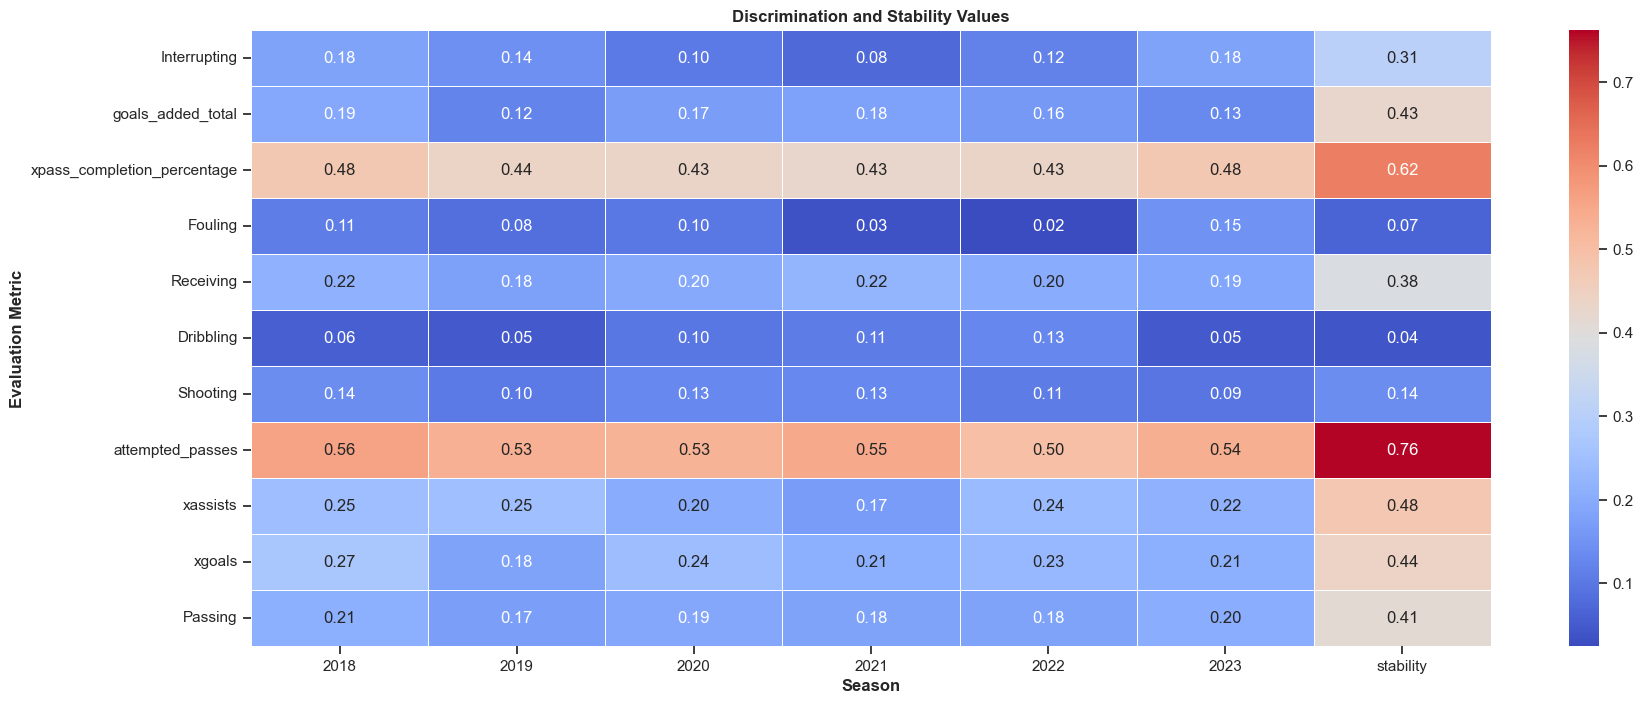

In [320]:
plt.figure(figsize=(20, 8))
sns.heatmap(final_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Discrimination and Stability Values', fontweight = 'bold')
plt.xlabel('Season', fontweight='bold')
plt.ylabel('Evaluation Metric', fontweight='bold')

## Write output
folder = 'results'
if not os.path.exists(folder):
    os.mkdir(folder)
export_path = folder + '/' + 'heatmap' + '.png'
plt.savefig(export_path)

In [317]:
lineplot_df['index'].unique()

array(['Interrupting', 'goals_added_total', 'xpass_completion_percentage',
       'Fouling', 'Receiving', 'Dribbling', 'Shooting',
       'attempted_passes', 'xassists', 'xgoals', 'Passing'], dtype=object)

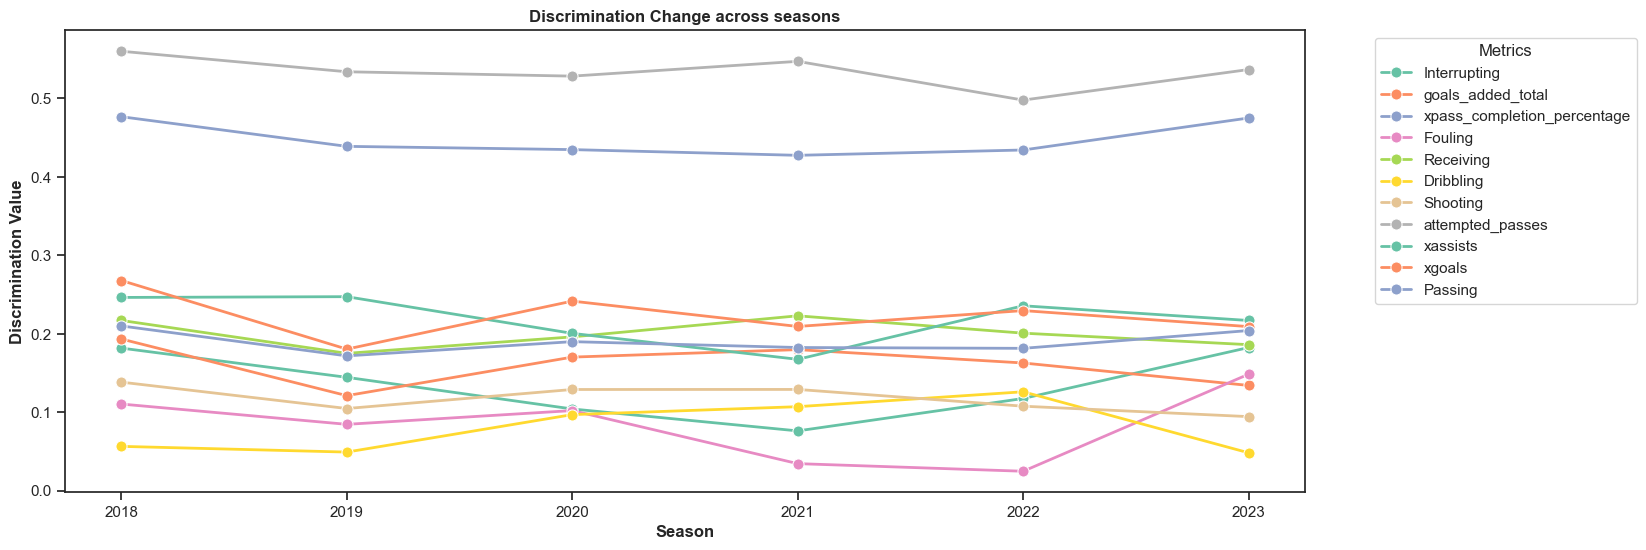

In [325]:
## Lineplot
lineplot_df = final_df.drop('stability', axis = 1).reset_index().melt( id_vars='index', var_name='season', value_name='discrimination')
lineplot_df

# Set a professional style
sns.set(style="ticks")

# Define a custom color palette
custom_palette = sns.color_palette("Set2", n_colors=lineplot_df['index'].nunique())

plt.figure(figsize=(16, 6))
sns.lineplot(x='season',
             y='discrimination',
             hue='index',
             data=lineplot_df,
             marker='o',
             palette=custom_palette,
            linewidth=2,
             markersize=8)

plt.title('Discrimination Change across seasons', fontweight = 'bold')
plt.xlabel('Season', fontweight = 'bold')
plt.ylabel('Discrimination Value', fontweight = 'bold')
# Move the legend outside
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

## Write output
folder = 'results'
if not os.path.exists(folder):
    os.mkdir(folder)
export_path = folder + '/' + 'lineplot' + '.png'
plt.savefig(export_path, bbox_inches='tight')

### Filtering out the player matches where he played less than 10 mins and did not play as CM

In [225]:
# #condition1 = player_xgoals['general_position'] == 'CM'
# condition2 = player_xgoals['minutes_played']>=10

In [226]:
# player_xgoals=player_xgoals[condition2]

In [326]:
# player_xgoals

In [327]:
# adding the season name to the above dataset

# player_xgoals = pd.merge(player_xgoals, games, on='game_id', how='left')

In [328]:
# def filter_metric(players_df, games_df, client=asa_client, method='get_player_xgoals', start_season=2020, end_season=2023):
#     '''
#     returns df of player specific metric in the given season start to end ranges
#     returned df contains the metric and the season_name column
#     '''
#     desired_range = [str(yr) for yr in list(range(start_season, end_season+1))]
#     players_df = players_df[players_df['season_name'].apply(lambda seasons: set(seasons).issuperset(set(desired_range)))]    
    
#     # getting the specific metric
#     player_id_list = list(players_df.player_id.unique())
    
#     dfs = []
    
#     # get the method based on the client and the method name specified as arguments
#     if hasattr(client, method):
#         func = getattr(client, method)
    
#     # columns to keep based on provided method
    
#     if method == 'get_player_xgoals':
#         columns_to_keep = ['player_id', 'minutes_played','xgoals', 'goals', 'season_name']
#     if method == 'get_player_xpass':
#         columns_to_keep = ['player_id', 'minutes_played', 'attempted_passes', 'pass_completion_percentage','season_name']
#     if method == 'get_player_goals_added' or method == 'get_goalkeeper_goals_added':
#         columns_to_keep = ['player_id', 'minutes_played', 'data', 'season_name']   
#     if method == 'get_goalkeeper_xgoals':
#         columns_to_keep = ['player_id', 'minutes_played', 'xgoals_gk_faced', 'saves', 'goals_conceded','season_name']         
        
#     # iterate to get the dfs per player id
#     for player_id in tqdm(player_id_list):
#         print(f"Getting the metrics for {player_id}") 
#         df = func(leagues = 'mls', player_ids = player_id, season_name=desired_range, split_by_games = True)
        
#         # filter to meet minimum play time
#         df = df[df['minutes_played']>=10]
        
#         # add season name to the df
#         df = pd.merge(df, games_df, on='game_id', how='left')
        
#         # keep only wanted columns
#         df = df[columns_to_keep].sort_values(by='season_name')
        
#         dfs.append(df)
    
#     # concatenate and return result
#     df_concat = pd.concat(dfs, ignore_index=True)
    
#     return df_concat

### Discrimination ability of a metric within a season computation

In [329]:
# # Discrimination - Most of the variability between player metrics reflects the true variation in player ability.
# # and not chance variation or noise from small sample sizes.

# # we compare the average intrinsic variability of a metric to the total between player variation in this metric.


# def discrimination_season(df, metric='xgoals', season = 2020):
#     ''' returns discrimination ability of the metric in the specified season''' 
#     # Filter rows with non-null values in the specified column
#     data = df[['season_name', 'player_id', metric]].dropna(subset=[metric])
#     # Filter rows based on the specified season
#     data = data[data['season_name'] == season]
    
#     # Calculate sample intra_variance and sample cross_variance
#     data['cross_variance'] = data[metric].var(ddof=1)
#     result_data = data.groupby('player_id').agg(
#         intra_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=1)),
#         cross_variance=pd.NamedAgg(column='cross_variance', aggfunc='mean')
#     )
    
#     # Calculate and return the discrimination score
#     return 1 - (result_data['intra_variance'].mean() / result_data['cross_variance'].mean())
    
#     # return result_data

## Stability

In [386]:
# Stability helps in understanding a player's metric across seasons
# it could be used for future acquisitions. 
# If we have a stable metric we have more confidence that this year's performance will be predictive of next year's performance.
# A metric can become unstable particularly if it is context dependent, (eg players performance varies due to team changes)
# Or, if a player's skill set tends to change year to year.

# We define stability as a metric which describes how much we expect a single player metric to vary over time after removing chanve variability.
# The metric specifically targets the sensitivity of a metric to change in context or intrinsic player skill over time.

In [331]:
# def stability_scores(df, metric='xgoals'):
#     '''
#     returns the stability metric 
#     '''
    
#     btw_season_variance = df.groupby('player_id').agg(
#        bs_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=1))
#     )['bs_variance'].mean()
    
#     within_season_player_variance = df.groupby(['player_id', 'season_name']).agg(
#         wsp_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=1))
#     )['wsp_variance'].mean()
    
#     overall_variance = df[metric].var(ddof=1)
    
#     stability = 1 - ((btw_season_variance - within_season_player_variance) / (overall_variance - within_season_player_variance))
    
#     return stability
        
        